In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import datasets

In [2]:
meta_path = '../../data/LANL_V3.meta.tsv'
seq_path = '../../data/LANL_V3.fasta'

dataset_root = '../../datasets/'
results_root = '../../results/'

In [3]:
shuffle_stream = np.random.RandomState(seed = 1234)

In [4]:
seq_info = {}

with open(seq_path) as handle:
    for seqR in SeqIO.parse(handle, 'fasta'):
        seq_info[seqR.id] = str(seqR.seq.ungap('-').translate())
print(len(seq_info))

/deepdata/share/conda-envs/envs/ai-tools/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


221028


In [5]:
meta_df = pd.read_csv(meta_path, sep = '\t')
meta_df['sequence'] = meta_df['Accession'].map(seq_info.get)
meta_df.head()

,#,Patient Code,PAT id(SSAM),Accession,Name,Subtype,Country,Sampling Year,Coreceptor,Sample Tissue,HXB2/MAC239 start,HXB2/MAC239 stop,Sequence Length,Organism,sequence
0,1,LAI,19535.0,A04321,IIIB_LAI,B,FRANCE,1983.0,CXCR4,NaN,455,9636,9193,HIV-1,CTRPNNNTRKSIRIQRGPGRAFVTIGKIGNMRQAHC
1,2,LAI,19535.0,A07867,LAI-J19,B,FRANCE,1983.0,NaN,NaN,455,9636,9193,HIV-1,CTRPNNNTRKSIRIQRGPGRAFVTIGKIGNMRQAHC
2,3,SUBJECT_4,768.0,AB001137,SUBJECT_4,B,JAPAN,NaN,NaN,spleen,7110,7217,105,HIV-1,CTRPNNNTRKGINIGPGRALFYATDIIGDIRQAHC
3,4,SUBJECT_4,768.0,AB001138,SUBJECT_4,B,JAPAN,NaN,NaN,spleen,7110,7217,105,HIV-1,CTRPNNNTRKGINIGPGRALFYATDIIGDIRQAHC
4,5,SUBJECT_4,768.0,AB001139,SUBJECT_4,B,JAPAN,NaN,NaN,spleen,7110,7217,105,HIV-1,CTRPNNNTRKGIHIGPGRGLFYATDIIGDIRQAHC


## Coreceptor

## Dataset Statistics

In [6]:
# Infer X4/R5 status from the provided Coreceptor column. 
# Keeping in mind that is may be labeled as:
# CCR5 CXCR4

coreceptor_data = meta_df.dropna(subset = ['Coreceptor']).copy()
coreceptor_data['is_x4'] = coreceptor_data.Coreceptor.str.contains('CXCR4')
coreceptor_data['is_r5'] = coreceptor_data.Coreceptor.str.contains('CCR5')
coreceptor_data['is_dual'] = coreceptor_data['is_r5'] & coreceptor_data['is_x4']
coreceptor_data['is_labeled'] = coreceptor_data['is_r5'] | coreceptor_data['is_x4']

agg = {'is_x4': 'any',
       'is_r5': 'any',
       'is_dual': 'any',
       'is_labeled': 'any',
       'Accession': 'first'}

coreceptor_data = coreceptor_data.groupby('sequence', as_index=False).agg(agg)

## Dataset Creation

In [8]:
# TODO: Add BibTeX citation
# Find for instance the citation on arxiv or on the dataset repo/website
_CITATION = """\
@InProceedings{huggingface:dataset,
title = {HIV V3 Coreceptor prediction dataset},
author={Will Dampier
},
year={2021}
}
"""

# TODO: Add a link to an official homepage for the dataset here
_HOMEPAGE = ""

# TODO: Add the licence for the dataset here if you can find it
_LICENSE = ""

# TODO: Add description of the dataset here
# You can copy an official description
_DESCRIPTION = """\
This dataset was constructured from a download of the LANL database for all V3 sequences that had any coreceptor
annotation. The site's tools were used to trim, align, and translate the sequence into in-frame amino acids.
The labels are stored as Array2D objects with the first column corresponding to R5 tropism and the second as X4 tropism.
"""


In [9]:
features = datasets.Features({
    'sequence': datasets.Value('string'),
    'id': datasets.Value('string'),
    'CXCR4': datasets.Value('bool'),
    'CCR5': datasets.Value('bool'),
    'fold': datasets.Value('int32')
})

training_folds = shuffle_stream.randint(0,5, size = coreceptor_data['sequence'].values.shape)

corecp_info = datasets.DatasetInfo(description = _DESCRIPTION,
                                  features = features,
                                  homepage=_HOMEPAGE, license = _LICENSE, citation=_CITATION)
corecpt_dset = datasets.Dataset.from_dict(mapping = {'sequence': coreceptor_data['sequence'].values,
                                                     'id': coreceptor_data['Accession'].values,
                                                     'CXCR4': coreceptor_data['is_x4'].values,
                                                     'CCR5': coreceptor_data['is_r5'].values,
                                                     'fold': training_folds
                                                    },
                                          info = corecp_info,
                                          features = features)
corecpt_dset.save_to_disk(dataset_root + 'V3_coreceptor')

## Bodysite

## Dataset Statistics

In [10]:
tissue_rename = {'plasma': 'periphery-tcell',
                 'PBMC': 'periphery-tcell',
                 'CD4+ T cells': 'periphery-tcell',
                 'serum': 'periphery-tcell',
                 'CSF': 'CNS',
                 'blood': 'periphery-tcell',
                 'breast milk': 'breast-milk',
                 'lymph node': 'organ',
                 'brain': 'CNS',
                 'supernatant': None,
                 'CD4+ T cell supernatant': 'periphery-tcell',
                 'semen': 'male-genitals',
                 'T cells': 'periphery',
                 'cervix': 'female-genitals',
                 'resting CD4+ T cells': 'periphery-tcell',
                 'spleen': 'organ',
                 'effector memory CD4+ T cells': 'periphery-tcell',
                 'vaginal fluid': 'female-genitals',
                 'umbilical cord plasma': 'umbilical-cord',
                 'seminal plasma': 'male-genitals',
                 'foreskin': 'male-genitals',
                 'bone marrow': 'periphery-tcell',
                 'transitional memory T cells': 'periphery-tcell',
                 'colon': 'gastric',
                 'rectum': 'gastric',
                 'central memory T cells': 'periphery-tcell',
                 'seminal cells': 'male-genitals',
                 'lung': 'lung',
                 'lymph node CD4+ T cells': 'periphery-tcell',
                 'jejunum': 'gastric',
                 'vagina': 'female-genitals',
                 'lamina propria mononuclear cells': 'periphery-tcell',
                 'BAL': 'lung',
                 'CD14+ monocytes': 'periphery-monocyte',
                 'saliva': None,
                 'ileum': 'gastric',
                 'activated CD4+ T cells': 'periphery-tcell',
                 'monocyte': 'periphery-monocyte',
                 'GALT': 'gastric',
                 'liver': 'organ',
                 'urine': None,
                 'naive CD4+ T cells': 'periphery-tcell',
                 'meninges': None,
                 'sputum': 'lung',
                 'kidney': 'organ',
                 'effector memory T cells': 'periphery-tcell',
                 'vaginal cells': 'female-genitals',
                 'placenta': 'umbilical-cord',
                 'rectal fluid': 'gastric',
                 'urethra': 'male-genitals',
                 'T-cell': 'periphery-tcell',
                 'CD8+ T cells': 'periphery-tcell',
                 'prostate': 'male-genitals',
                 'intestine': 'gastric',
                 'feces': 'gastric',
                 'stomach': 'gastric',
                 'choroid plexus': 'gastric',
                 'PMBC': 'periphery-tcell',
                 'epidermis': 'organ',
                 'sigmoideum': 'gastric',
                 'skin tumor': None,
                 'diaphragm': 'lung',
                 'testis': 'male-genitals',
                 'PBMC supernatant': 'periphery-tcell',
                 'gastric aspirate': 'gastric',
                 'spinal cord': 'CNS',
                 'stem memory T cells': 'periphery-tcell',
                 'thymus': 'organ',
                 'terminally differentiated T cells': 'periphery-tcell',
                 'CD16+ monocytes': 'periphery-monocyte',
                 'dendrites': 'CNS',
                 'qVOA': None,
                 'urine cells': None,
                 'pancreas': 'organ',
                 'breast milk supernatant': None,
                 'aorta': None,
                 'cervicovaginal secretions': 'female-genitals',
                 'MT-2': None,
                 'glioma': None,
                 'prostatic secretion': 'male-genitals',
                 'esophagus': 'gastric',
                 'adrenal gland': 'organ'}

In [11]:
# Infer X4/R5 status from the provided Coreceptor column. 
# Keeping in mind that is may be labeled as:
# CCR5 CXCR4

bodysite_data = meta_df.dropna(subset = ['Sample Tissue']).copy()
bodysite_data['id'] = bodysite_data['Accession']
bodysite_data['body_site'] = bodysite_data['Sample Tissue'].map(tissue_rename.get)
bodysite_data.dropna(subset = ['body_site'], inplace=True)

agg_bodysite = pd.pivot_table(bodysite_data,
                              index = 'sequence',
                              columns = 'body_site',
                              values = 'Accession',
                              aggfunc = ['count', 'first'])


found_bodysite = agg_bodysite['count'].fillna(0)>0
found_bodysite['id'] = agg_bodysite['first'].apply(lambda row: row.dropna().iloc[0], axis=1)
found_bodysite.reset_index(inplace=True)
found_bodysite.head()

body_site,sequence,CNS,breast-milk,female-genitals,gastric,lung,male-genitals,organ,periphery,periphery-monocyte,periphery-tcell,umbilical-cord,id
0,,False,False,False,False,False,False,False,False,False,True,False,KF374133
1,*DLATIQEKVYIWDQGKHFIQEK**EI*DKHI,False,False,False,False,False,False,False,False,False,True,False,KU901995
2,*GLIIIQGKV*G*DQDKHSMQQET**ET*DKHI,False,False,False,False,False,False,False,False,False,True,False,FJ444464
3,*TRPNNNTRKSIHIGPGRAFYATGEMIGDIRQAYC,False,False,False,False,False,False,False,False,False,True,False,AF535281
4,*TRPNNNTRKSIPMGPGRAFYTTGQITGDIRQAHC,False,False,False,False,False,False,True,False,False,False,False,Z34434


In [13]:
sites = ['periphery-tcell', 'periphery-monocyte', 'CNS', 'breast-milk', 'female-genitals', 'male-genitals', 'gastric', 'lung',  'organ']

ds_mask = shuffle_stream.rand(len(found_bodysite))<0.05
keep_mask = (found_bodysite[sites[1:]].any(axis=1).values) | ds_mask
found_bodysite = found_bodysite.loc[keep_mask].copy()

found_bodysite['fold'] = shuffle_stream.randint(0,5, size = found_bodysite['sequence'].values.shape)

In [14]:
bodysite_counts = found_bodysite[sites].sum()
bodysite_counts['multiple'] = (found_bodysite[sites].sum(axis=1)>=2).sum()
bodysite_counts

body_site
periphery-tcell       3034
periphery-monocyte     111
CNS                   1217
breast-milk            487
female-genitals        481
male-genitals          603
gastric                450
lung                   255
organ                  654
multiple              1558
dtype: int64

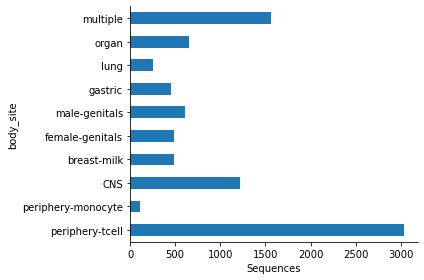

In [15]:
fig, ax = plt.subplots(1,1)

ax = bodysite_counts.plot(kind = 'barh', ax=ax)
ax.set_xlabel('Sequences')
sns.despine(ax=ax)

fig.tight_layout()

fig.savefig(results_root + 'Fig2_bodysite.png')

## Dataset Creation

In [16]:
# TODO: Add BibTeX citation
# Find for instance the citation on arxiv or on the dataset repo/website
_CITATION = """\
@InProceedings{huggingface:dataset,
title = {HIV V3 Tissue Isolation Dataset},
author={Will Dampier},
year={2021}
}
"""

# TODO: Add a link to an official homepage for the dataset here
_HOMEPAGE = ""

# TODO: Add the licence for the dataset here if you can find it
_LICENSE = ""

# TODO: Add description of the dataset here
# You can copy an official description
_DESCRIPTION = """\
This dataset was constructured from a download of the LANL database for all V3 sequences that had any annotation of tissue of isolation
annotation. The site's tools were used to trim, align, and translate the sequence into in-frame amino acids.
The diverse categories provided by the database were summarized into a wider set:
 - periphery
 - CNS
 - male & female genital tracks
 - gastric track
 - lung
 - umbillical cord
 - breast-milk
 - organ associated

The labels are stored as a `ClassLabel` object.
"""

In [17]:
features = datasets.Features({
    'sequence': datasets.Value('string'),
    'id': datasets.Value('string'),
    'fold': datasets.Value('int32')
})
for feat in sites:
    features[feat] = datasets.Value('bool')
    

bodysite_info = datasets.DatasetInfo(description = _DESCRIPTION,
                                  features = features,
                                  homepage=_HOMEPAGE, license = _LICENSE, citation=_CITATION)

bodysite_dset = datasets.Dataset.from_pandas(found_bodysite, 
                                         info = bodysite_info, 
                                         features = features)
bodysite_dset.save_to_disk(dataset_root + 'V3_bodysite')